In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

In [2]:
!pip install yfinance 

In [3]:
import yfinance as yf


In [4]:
def get_pair(name):
    curr = yf.Ticker(name)
    hist = curr.history(period = 'max')
    return (hist)

In [18]:
df = get_pair('CADUSD=X') #data pull
df.columns = ['Curr Open', 'Curr High', 'Curr Low', 'Curr Close', 'Volume', 'Dividends', 'Stock Splits']
df.reset_index(inplace = True)
df

,Date,Curr Open,Curr High,Curr Low,Curr Close,Volume,Dividends,Stock Splits
0,2003-09-17,0.7317,0.7334,0.7297,0.7317,0,0,0
1,2003-09-18,0.7321,0.7355,0.7307,0.7345,0,0,0
2,2003-09-19,0.7342,0.7431,0.7337,0.7423,0,0,0
3,2003-09-22,0.7455,0.7482,0.7378,0.7384,0,0,0
4,2003-09-23,0.7381,0.7431,0.7365,0.7380,0,0,0
...,...,...,...,...,...,...,...,...
4438,2020-10-09,0.7580,0.7625,0.7578,0.7580,0,0,0
4439,2020-10-12,0.7616,0.7633,0.7609,0.7616,0,0,0
4440,2020-10-13,0.7627,0.7635,0.7607,0.7626,0,0,0
4441,2020-10-14,0.7611,0.7624,0.7601,0.7609,0,0,0


In [19]:
wti = get_pair('CL=F') #data pull
wti.columns = ['Oil Open', 'Oil High', 'Oil Low', 'Oil Close', 'Oil Volume', 'Oil Dividends', 'Oil Stock Splits']
wti.reset_index(inplace = True)
wti

,Date,Oil Open,Oil High,Oil Low,Oil Close,Oil Volume,Oil Dividends,Oil Stock Splits
0,2000-08-23,31.95,32.80,31.95,32.05,79385,0,0
1,2000-08-24,31.90,32.24,31.40,31.63,72978,0,0
2,2000-08-25,31.70,32.10,31.32,32.05,44601,0,0
3,2000-08-28,32.04,32.92,31.86,32.87,46770,0,0
4,2000-08-29,32.82,33.03,32.56,32.72,49131,0,0
...,...,...,...,...,...,...,...,...
5049,2020-10-09,41.31,41.47,40.38,40.60,331703,0,0
5050,2020-10-12,40.40,40.45,39.04,39.43,322035,0,0
5051,2020-10-13,39.53,40.53,39.35,40.20,375470,0,0
5052,2020-10-14,40.19,41.16,39.82,41.04,375470,0,0


In [21]:
wti.dtypes

Date                datetime64[ns]
Oil Open                   float64
Oil High                   float64
Oil Low                    float64
Oil Close                  float64
Oil Volume                   int64
Oil Dividends                int64
Oil Stock Splits             int64
dtype: object

In [26]:
d2 = pd.merge(df, wti, on = 'Date', how = 'inner')
d2[['Date', 'Curr Close', 'Oil Close']].head()

,Date,Curr Close,Oil Close
0,2003-09-17,0.7317,27.03
1,2003-09-18,0.7345,27.17
2,2003-09-19,0.7423,27.03
3,2003-09-22,0.7384,26.96
4,2003-09-23,0.7380,27.13


In [30]:
pair = d2[['Date', 'Curr Close', 'Oil Close']].copy(deep = True)
pair['Curr Close'] = pair['Curr Close']*100

In [31]:
def plotter(df, x, y): 
    plt.figure(figsize = (20,10))
    for i in range(0, len(y)):
        plt.plot(df[x], df[y[i]], label = y[i])
    plt.grid()
    plt.legend()
    plt.show()

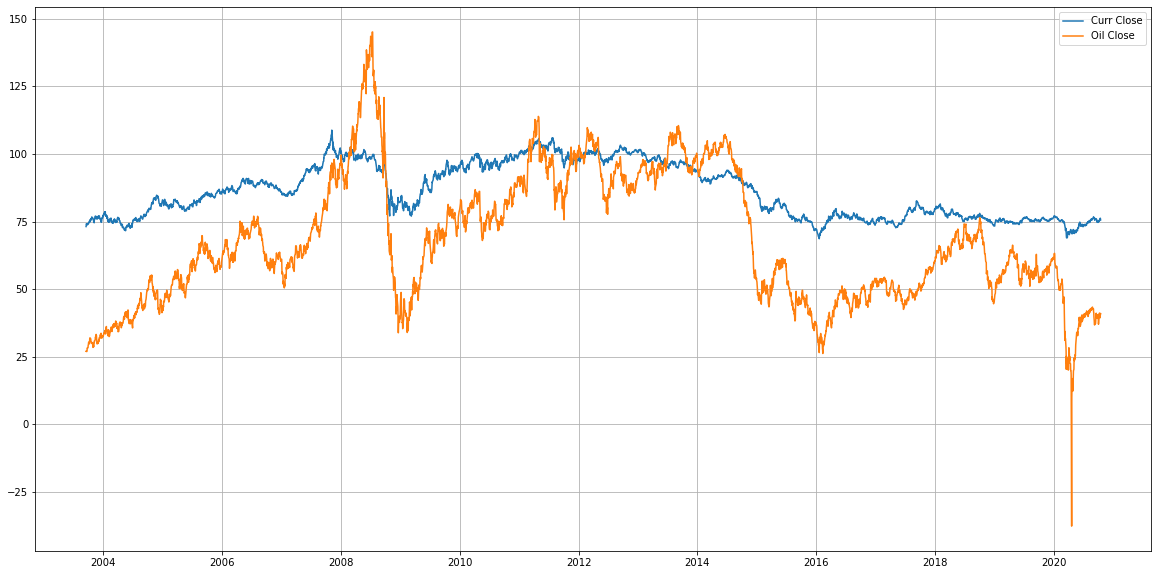

In [32]:
plotter(pair, 'Date', ['Curr Close', 'Oil Close'])

In [34]:
def gen_z_score(lookback, df, on_column): 
    df["Mean"] = df[on_column].rolling(lookback).mean()
    df["Std"] = df[on_column].rolling(lookback).std()
    df[on_column + " Z Score"] = (df[on_column] - df["Mean"])/df["Std"]
    return(df)

In [35]:
pair['Diff'] = pair['Curr Close'] - pair['Oil Close']
pair_z = gen_z_score(15, pair, 'Diff')

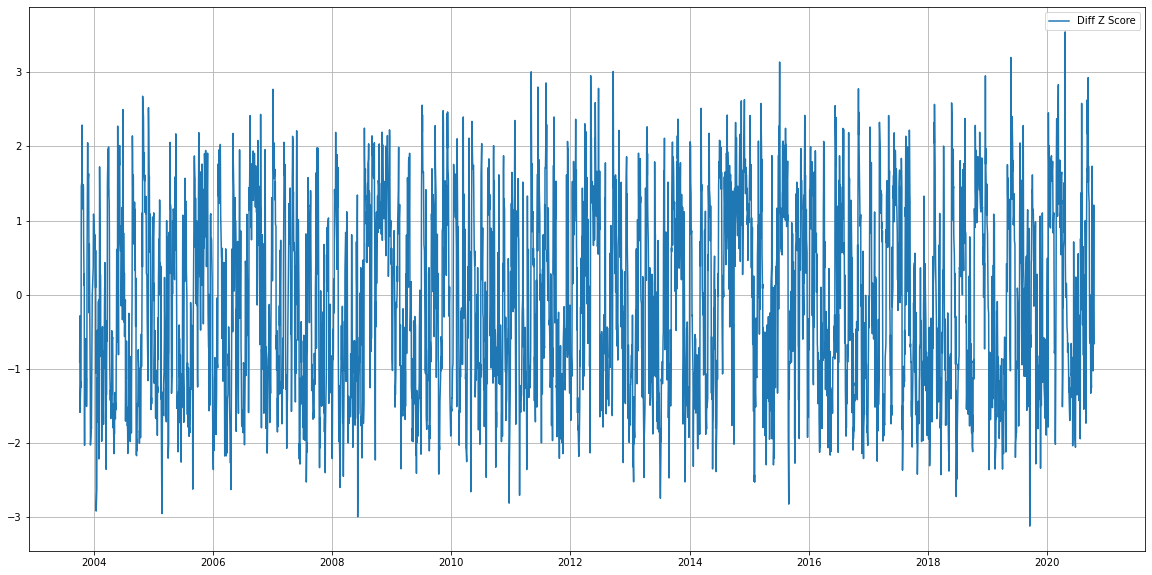

In [36]:
plotter(pair_z, 'Date', ['Diff Z Score'])

In [39]:
def backtester(backtest, entry, z_key, underlying_key):
    backtest["Position"] = 0
    mask = backtest[z_key] >= entry
    backtest.loc[mask, "Position"] = -1 
    mask2 = backtest[z_key] <= -entry
    backtest.loc[mask2, "Position"] = 1 
    backtest["Tick Change"] = -backtest[underlying_key].diff(-1)
    backtest["Tick PnL"] = backtest["Tick Change"] * backtest["Position"]
    backtest["Cum PnL"] = backtest["Tick PnL"].cumsum()
    return(backtest) 

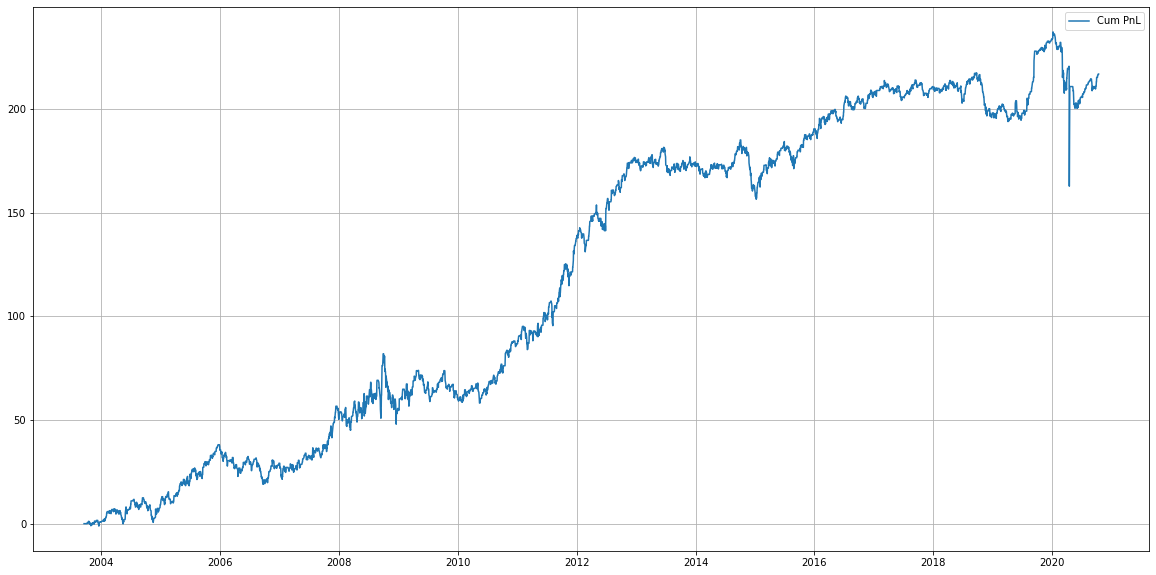

In [40]:
btest = backtester(pair_z, 0.8, 'Diff Z Score', 'Diff')
plotter(btest, 'Date', ['Cum PnL'])

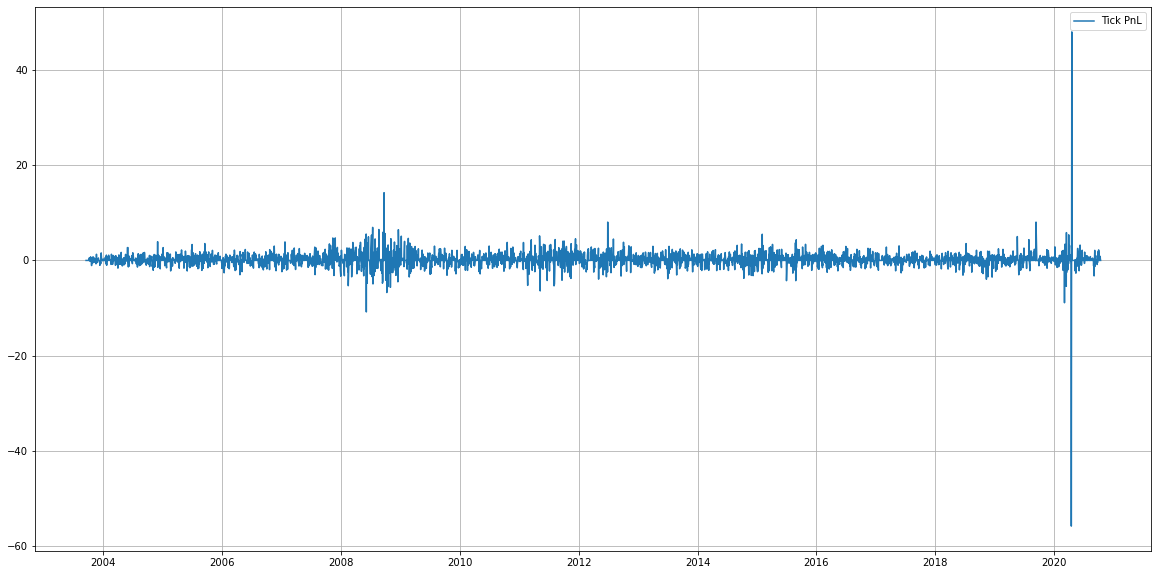

In [41]:
plotter(btest, 'Date',['Tick PnL'])